In [10]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
#%matplotlib notebook

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

from matplotlib import animation, rc
from IPython.display import HTML

In [11]:
def prepare_training_data(df_F, df_D, df_Dt, d):
    
    DF = []
    for i in range(d):
        if i == 0:
            DF = np.concatenate((df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis = 1)
        else:
            DF = np.concatenate((DF, df_F.shift(d-i).values, df_D.shift(d-i).values, df_Dt.shift(d-i).values), axis=1)

    DF = DF[d:,:]
    Dy = np.concatenate((df_D.values, df_Dt.values), axis=1)
    Dy = Dy[d:,:]
    
    return DF, Dy

In [12]:
def train_test_split(DF, Dy, d, x_scaler, y_scaler):

    dim = np.shape(Dy)

    n_nodes = int(dim[1]/2)
    n_y = dim[1]
    x = np.linspace(0,1, n_nodes)

    #Scaling
    DFscaled = x_scaler.transform(DF)
    Dyscaled = y_scaler.transform(Dy)

    X_train = DFscaled
    Y_train = Dyscaled

    #Train test split
    train_portion = 0.8
    n_timesteps = len(X_train[:,0])
    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]

    n_features = int(x_train.shape[1]/d)
    x_train = x_train.reshape((x_train.shape[0], d, n_features))
    x_test = x_test.reshape((x_test.shape[0], d, n_features))

    return x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x

In [87]:
def initialize_model(n_units, x_train, y_train):
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(n_units))
    #model.add(Dropout(0.2))
    model.add(Dense(len(y_train[0,:])))
    adam = Adam(lr=0.0001)
    model.compile(loss='mae', optimizer=adam)
    
    earlystop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=15, verbose=1, mode='auto')
    callback_list = [earlystop]
    return model, callback_list

In [14]:
def get_error(predictions, y_test):
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [15]:
def independent_predictions(x_test):

    input_i = np.copy(x_test[0,:,:])
    input_i_reshaped = input_i.reshape((1,d,n_features))

    #input_dim = x_test[0,:,:].shape

    future_timesteps = len(x_test[:,0,0])-1
    preds = np.zeros([future_timesteps, n_y])

    force = np.copy(x_test[:,:,:(n_nodes)])
    #model.reset_states()
    for i in range(future_timesteps): 
        pred = model.predict(input_i_reshaped)
        preds[i, :] = pred[0]

        input_i[0:d-1,:] = input_i[1:d,:]
        input_i[d-1,:n_nodes] = force[i+1,d-1,:]
        input_i[d-1,n_nodes:] = pred[0]

        input_i_reshaped = input_i.reshape((1,d,n_features))
        
    return preds

In [16]:
def get_scalers(DF, Dy):
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    x_scaler.fit_transform(DF)
    y_scaler.fit_transform(Dy)
    
    return x_scaler, y_scaler

In [17]:
def get_batch_scalers(n_batches):
    
    #Simple version
    for i in range(n_batches):
        
        df_D = pd.read_csv('../training_batches/D' + str(i+1) + '.csv')
        df_F = pd.read_csv('../training_batches/F' + str(i+1) + '.csv')
        df_Dt = pd.read_csv('../training_batches/Dt' + str(i+1) + '.csv')
        
        if i == 0:  
            x_range = df_D.values.max() - df_D.values.min()
            imax = i
        
        else:
            new_x_range = df_D.values.max() - df_D.values.min()
            
            if new_x_range > x_range:
                x_range = new_x_range
                imax = i
                
    df_D = pd.read_csv('../training_batches/D' + str(imax+1) + '.csv')
    df_F = pd.read_csv('../training_batches/F' + str(imax+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/Dt' + str(imax+1) + '.csv')
    
    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    return x_scaler, y_scaler

In [88]:
######################### BATCH TRAINING ########################################

n_batches = 1
d = 10

t0 = time.time()

x_scaler, y_scaler = get_batch_scalers(n_batches)

for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/hD' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/hF' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/hDt' + str(iteration+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    if iteration == 0:
        model, callback_list = initialize_model(100, x_train, y_train)
    
    model.fit(x_train, y_train, epochs=500, callbacks=callback_list, batch_size=1000, verbose=1, shuffle=False)
    #model.fit(x_train, y_train, epochs=100, callbacks=None, batch_size=1000, verbose=1, shuffle=False)
    
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    total_time = time.time() - t0
    
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

Epoch 1/500
23992/23992 [==============================] - 6s 255us/step - loss: 0.4100
Epoch 2/500
23992/23992 [==============================] - 4s 173us/step - loss: 0.2688 0s - loss: 0
Epoch 3/500
23992/23992 [==============================] - 4s 172us/step - loss: 0.1790
Epoch 4/500
23992/23992 [==============================] - 4s 176us/step - loss: 0.1236
Epoch 5/500
23992/23992 [==============================] - 5s 197us/step - loss: 0.0985
Epoch 6/500
23992/23992 [==============================] - 5s 196us/step - loss: 0.0806
Epoch 7/500
23992/23992 [==============================] - 5s 198us/step - loss: 0.0660
Epoch 8/500
23992/23992 [==============================] - 5s 212us/step - loss: 0.0546
Epoch 9/500
23992/23992 [==============================] - 5s 194us/step - loss: 0.0459
Epoch 10/500
23992/23992 [==============================] - 5s 210us/step - loss: 0.0398
Epoch 11/500
23992/23992 [==============================] - 5s 196us/step - loss: 0.0356 2s -
Epoch 12/500

23992/23992 [==============================] - 5s 220us/step - loss: 0.0047
Epoch 93/500
23992/23992 [==============================] - 5s 212us/step - loss: 0.0049
Epoch 94/500
23992/23992 [==============================] - 5s 193us/step - loss: 0.0045 1s - los
Epoch 95/500
23992/23992 [==============================] - 5s 229us/step - loss: 0.0043
Epoch 96/500
23992/23992 [==============================] - 5s 225us/step - loss: 0.0044
Epoch 97/500
23992/23992 [==============================] - 5s 212us/step - loss: 0.0046
Epoch 98/500
23992/23992 [==============================] - 5s 217us/step - loss: 0.0046
Epoch 99/500
23992/23992 [==============================] - 5s 220us/step - loss: 0.0044
Epoch 100/500
23992/23992 [==============================] - 5s 203us/step - loss: 0.0042
Epoch 101/500
23992/23992 [==============================] - 6s 232us/step - loss: 0.0043
Epoch 102/500
23992/23992 [==============================] - 5s 217us/step - loss: 0.0045
Epoch 103/500
23992/23

23992/23992 [==============================] - 5s 208us/step - loss: 0.0031
Epoch 183/500
23992/23992 [==============================] - 5s 199us/step - loss: 0.0031
Epoch 184/500
23992/23992 [==============================] - 5s 208us/step - loss: 0.0031
Epoch 185/500
23992/23992 [==============================] - 5s 205us/step - loss: 0.0032
Epoch 186/500
23992/23992 [==============================] - 5s 193us/step - loss: 0.0030 1s - loss: 
Epoch 187/500
23992/23992 [==============================] - 4s 187us/step - loss: 0.0031
Epoch 188/500
23992/23992 [==============================] - 5s 192us/step - loss: 0.0030
Epoch 189/500
23992/23992 [==============================] - 5s 192us/step - loss: 0.0030
Epoch 190/500
23992/23992 [==============================] - 5s 228us/step - loss: 0.0030
Epoch 191/500
23992/23992 [==============================] - 5s 204us/step - loss: 0.0031
Epoch 192/500
23992/23992 [==============================] - 5s 189us/step - loss: 0.0030
Epoch 193/50

In [31]:
len(x_train)

23992

In [56]:
#save best model
#trained on= gr_set1

#model.save('../models/RNN_gr_set1.h5')

#### CONTINUE TRAINING ####
#model = load_model('beam_model.h5')

#model.fit(x_train, y_train, epochs=100, verbose=1)

#model.save('beam_model.h5')

#del(model)

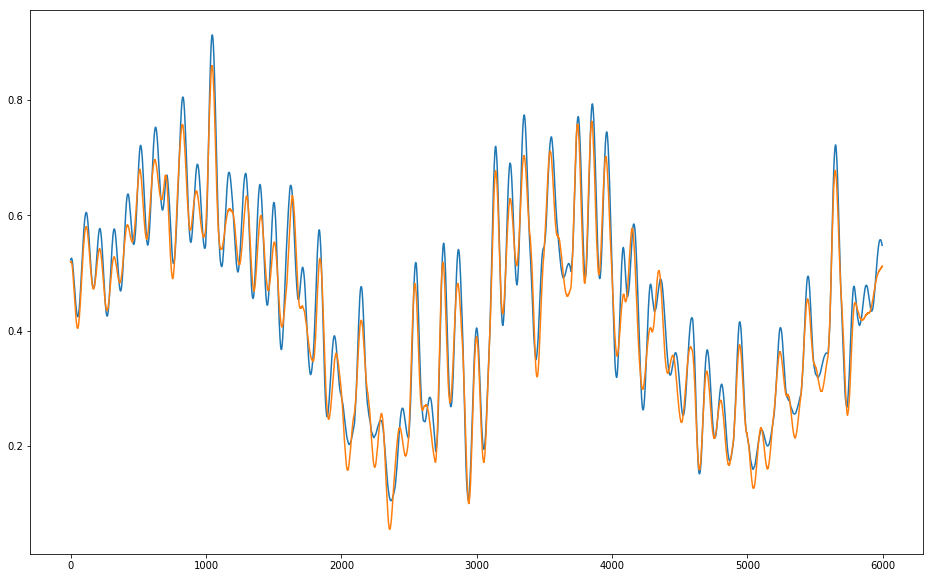

{'Iteration number': 1, 'Training Error': 0.11634210012495716, 'Test Error': 0.025627306723523063, 'Ind test error': 6.5326054583532507, 'Training time': 0.0, 'Total time': 10.651186466217041}


In [91]:
######################### BATCH TESTING ########################################

n_batches = 1
d = 10

t0 = time.time()
for iteration in range(n_batches):

    df_D = pd.read_csv('../training_batches/D' + str(iteration+1) + '.csv')
    df_F = pd.read_csv('../training_batches/F' + str(iteration+1) + '.csv')
    df_Dt = pd.read_csv('../training_batches/Dt' + str(iteration+1) + '.csv')

    DF, Dy = prepare_training_data(df_F, df_D, df_Dt, d)
    
    #if i == 0:
    #    x_scaler, y_scaler = get_scalers(DF, Dy)
    
    x_train, x_test, y_train, y_test, n_nodes, n_features, n_y, x = train_test_split(DF, Dy, d, x_scaler, y_scaler)
    
    ts = time.time()
    #if i == 0:
    #    model, callback_list = initialize_model(100, x_train, y_train)
    
    #model.fit(x_train, y_train, epochs=100, callbacks=callback_list, batch_size=len(x_train), verbose=0, shuffle=False)
    
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    y_test_u = y_scaler.inverse_transform(y_test)[:, 0:n_nodes]
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    #plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()

    
    total_time = time.time() - t0
    
    info = {'Iteration number': iteration+1, 'Training Error': training_error, 'Test Error': test_error, 'Ind test error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    print(info)

In [90]:
#Export results
np.savetxt("predictions.csv", pred_test_u, delimiter=",")
np.savetxt("preds.csv", pred_ind_u, delimiter=",")
np.savetxt("y_test.csv", y_test_u, delimiter=",")
np.savetxt("y_train.csv", y_test_u, delimiter=",")

In [40]:
pred_ind_all = independent_predictions(x_train)
pred_ind = pred_ind_all[:, 0:n_nodes]

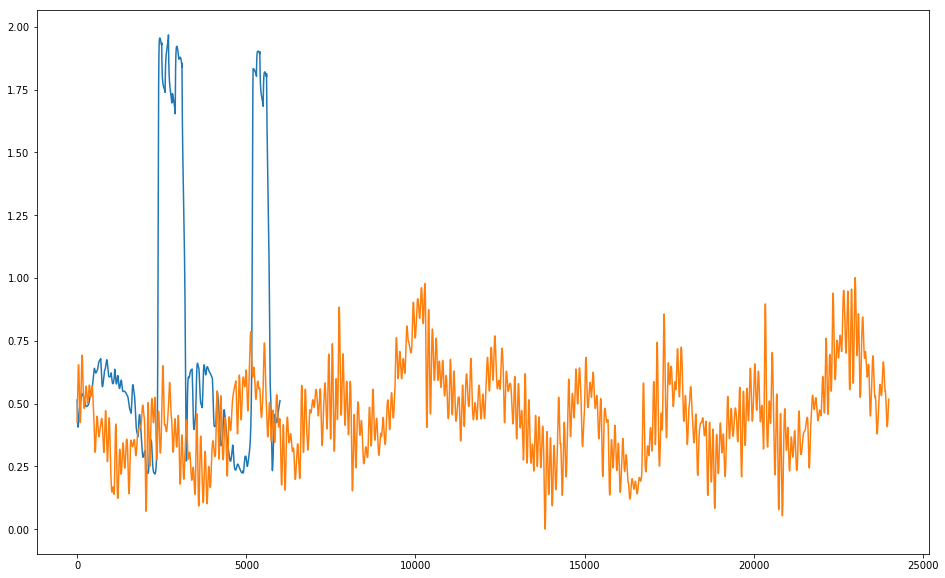

In [46]:
plt.figure(figsize=(16,10))
#plt.plot(pred_test[:,n_nodes-1], 'x')
plt.plot(pred_ind[:,n_nodes-1])
plt.plot(y_train[:, n_nodes-1])
plt.show()

In [89]:
DF.shape

(4995, 205)

In [91]:
df_D.values.shape

(5000, 21)

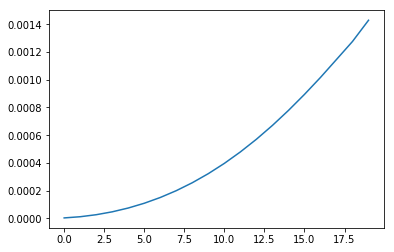

In [20]:
plt.plot(y_test_u[50,:])